# The Simulator Class

The most convenient way to use ``hera_sim`` is to use the ``Simulator`` class, which builds in all the primary functionality of the ``hera_sim`` package in an easy-to-use interface, and adds the ability to consistently write all produced effects into a ``pyuvdata.UVData`` object (and to file).


This notebook provides a brief tutorial on basic use of the ``Simulator`` class, followed by a longer, more in-depth tutorial that shows some advanced features of the class.

## Setup ##

In [1]:
import tempfile
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from astropy import units

import hera_sim
from hera_sim import Simulator, DATA_PATH, utils
from uvtools.plot import labeled_waterfall
%matplotlib inline

We'll inspect the visibilities as we go along by plotting the amplitudes and phases on different axes in the same figure. Here's the function we'll be using:

In [2]:
def waterfall(sim, antpairpol=(0,1,"xx"), figsize=(6,3.5), dpi=200, title=None):
    """Convenient plotting function to show amp/phase."""
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        dpi=dpi,
    )
    fig, ax1 = labeled_waterfall(
        sim.data,
        antpairpol=antpairpol,
        mode="log",
        ax=ax1,
        set_title=title,
    )
    ax1.set_xlabel(None)
    ax1.set_xticklabels(['' for tick in ax1.get_xticks()])
    fig, ax2 = labeled_waterfall(
        sim.data,
        antpairpol=antpairpol,
        mode="phs",
        ax=ax2,
        set_title=False,
    )
    return fig

## Basic Use ##

To get us started, let's make a ``Simulator`` object with 100 frequency channels spanning from 100 to 200 MHz, a half-hour of observing time using an integration time of 10.7 seconds, and a 7-element hexagonal array.

In [3]:
# Define the array layout.
array_layout = hera_sim.antpos.hex_array(
    2, split_core=False, outriggers=0
)

# Define the timing parameters.
start_time = 2458115.9  # JD
integration_time = 10.7  # seconds
Ntimes = int(30 * units.min.to("s") / integration_time)

# Define the frequency parameters.
Nfreqs = 100
bandwidth = 1e8  # Hz
start_freq = 1e8  # Hz

sim_params = dict(
    Nfreqs=Nfreqs,
    start_freq=start_freq,
    bandwidth=bandwidth,
    Ntimes=Ntimes,
    start_time=start_time, 
    integration_time=integration_time, 
    array_layout=array_layout,
)

# Create an instance of the Simulator class.
sim = Simulator(**sim_params)

### Overview ###

The ``Simulator`` class adds some attributes for conveniently accessing metadata:

In [4]:
# Observed frequencies in GHz
sim.freqs[::10]

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])

In [5]:
# Observed Local Sidereal Times (LSTs) in radians
sim.lsts[::10]

array([4.58108965, 4.58889222, 4.59669478, 4.60449734, 4.61229991,
       4.62010247, 4.62790503, 4.6357076 , 4.64351016, 4.65131273,
       4.65911529, 4.66691785, 4.67472042, 4.68252298, 4.69032555,
       4.69812811, 4.70593067])

In [6]:
# Array layout in local East-North-Up (ENU) coordinates
sim.antpos

{0: array([-7.30000000e+00,  1.26439709e+01, -4.36185665e-09]),
 1: array([ 7.30000000e+00,  1.26439709e+01, -3.99203159e-09]),
 2: array([-1.46000000e+01,  6.98581573e-09, -4.65185394e-09]),
 3: array([ 0.00000000e+00,  7.20559015e-09, -4.28202888e-09]),
 4: array([ 1.46000000e+01,  7.42536457e-09, -3.91220382e-09]),
 5: array([-7.30000000e+00, -1.26439709e+01, -4.57202631e-09]),
 6: array([ 7.30000000e+00, -1.26439709e+01, -4.20220125e-09])}

In [7]:
# Polarization array
sim.pols

['xx']

You can also generate a plot of the array layout using the ``plot_array`` method:

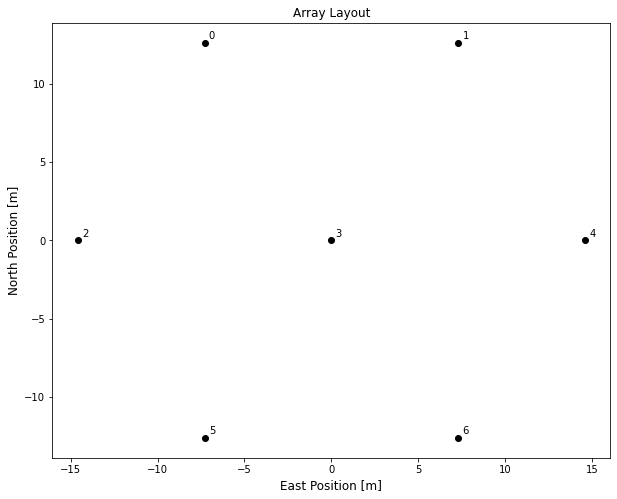

In [8]:
fig = sim.plot_array()

The ``data`` attribute can be used to access the ``UVData`` object used to store the simulated data and metadata:

In [9]:
type(sim.data)

pyuvdata.uvdata.uvdata.UVData

### Adding Effects ###

Effects may be added to a simulation by using the ``add`` method. This method takes one argument and variable keyword arguments: the required argument ``component`` may be either a string identifying the name of a ``hera_sim`` class (or an alias thereof, see below), or a callable object that has either ``lsts`` or  ``freqs`` (or both) as a parameter(s) and returns an object with shape (``lsts.size``, ``freqs.size``) or (``freqs.size``,) (granted, the ``Simulator`` does not do a check on the input parameters or the shape of returned values, but passing a callable object that returns something incorrectly shaped will likely result in an exception being raised). Let's walk through an example.

We'll start by simulating diffuse foreground emission. For simplicity, we'll be using the H1C season default settings so that the number of extra parameters we need to specify is minimal.

In [10]:
# Use H1C season defaults.
hera_sim.defaults.set("h1c")

In [11]:
# Start off by simulating some foreground emission.
sim.add("diffuse_foreground")

You have not specified how to seed the random state. This effect might not be exactly recoverable.


FixedFormatter should only be used together with FixedLocator


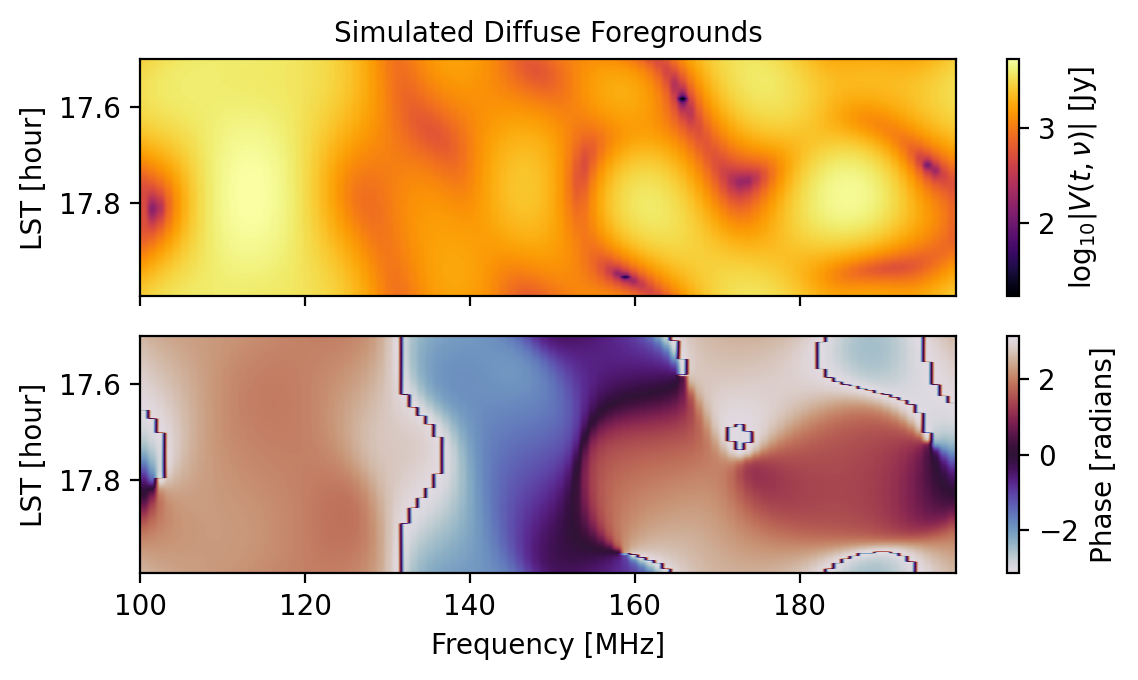

In [12]:
# Let's check out the data for the (0,1) baseline.
fig = waterfall(sim, title="Simulated Diffuse Foregrounds")
fig.tight_layout()

That was simple enough; however, basic use like this does not ensure that the simulation is as realistic as it can be with the tools provided by ``hera_sim``. For example, data that should be redundant is not redundant by default:

In [13]:
# (0,1) and (5,6) are redundant baselines, but...
np.all(sim.get_data(0,1,"xx") == sim.get_data(5,6,"xx"))

False

We can ensure that a simulated effect that should be redundant is redundant by specifying that we use a "redundant" seed:

In [14]:
sim.refresh()  # Clear the contents and zero the data
sim.add("diffuse_foreground", seed="redundant")

In [15]:
np.all(sim.get_data(0,1,"xx") == sim.get_data(5,6,"xx"))

True

In [16]:
# Go one step further with this example.
all_redundant = True
for red_grp in sim.red_grps:
    if len(red_grp) == 1:
        continue  # Nothing to see here
    base_vis = sim.get_data(red_grp[0])
    # Really check that data is redundant.
    for baseline in red_grp[1::]:
        all_redundant &= np.allclose(base_vis, sim.get_data(baseline))
all_redundant

True

### Retrieving Simulated Effects ###

The parameter values used for simulating an effect are stored so that the effect may be recovered at a later time by re-simulating the effect. For effects that have a random element (like bandpass gains or thermal noise), you'll want to make sure that the ``seed`` parameter is specified to ensure that the random state can be configured appropriately.

In [17]:
sim.refresh()
vis = sim.add("noiselike_eor", eor_amp=1e-3, seed="redundant", ret_vis=True)
sim.add("gains", seed="once")

In [18]:
# The data has been modified by the gains, so it won't match the original.
np.allclose(vis, sim.data.data_array)

False

In [19]:
# We can recover the simulated effect if we wanted to, though.
np.allclose(vis, sim.get("noiselike_eor"))

True

In [20]:
# Just to really drive the point home.
gains = sim.get("gains")
new_vis = vis.copy()
for ant1, ant2, pol, blt_inds, pol_ind in sim._iterate_antpair_pols():
    total_gain = gains[(ant1, pol[0])] * np.conj(gains[(ant2, pol[1])])
    new_vis[blt_inds,0,:,pol_ind] *= total_gain
np.allclose(new_vis, sim.data.data_array)

True

Each time a component is added to the simulation, it is logged in the history:

In [21]:
print(sim.data.history)

hera_sim v0.0.0: Added noiselikeeor using parameters:
eor_amp = 0.001
fringe_filter_type = tophat
hera_sim v0.0.0: Added bandpass using parameters:
bp_poly = <hera_sim.interpolators.Bandpass object at 0x7f416d10db80>



### Saving A Simulation ###

Finally, we'll often want to write simulation data to disk. The simplest way to do this is with the ``write`` method:

In [22]:
tempdir = Path(tempfile.mkdtemp())
filename = tempdir / "simple_example.uvh5"
sim.write(filename, save_format="uvh5")

In [23]:
filename in tempdir.iterdir()

True

In [24]:
# Check that the data is the same.
sim2 = Simulator(data=filename)
is_equiv = True
# Just do a basic check.
for attr in ("data_array", "freq_array", "time_array", "antenna_positions"):
    is_equiv &= np.all(getattr(sim.data, attr) == getattr(sim2.data, attr))
is_equiv

Telescope hera_sim is not in known_telescopes.


True

This concludes the section on basic use of the ``Simulator``. If you would like to know which effects can be simulated, then you can view all of the known models via:

In [25]:
print(hera_sim.components.list_all_components())

array:
  lineararray
  hexarray
foreground:
  diffuseforeground | diffuse_foreground
  pointsourceforeground | pntsrc_foreground
noise:
  thermalnoise | thermal_noise
rfi:
  stations | rfi_stations
  impulse | rfi_impulse
  scatter | rfi_scatter
  dtv | rfi_dtv
gain:
  bandpass | gains | bandpass_gain
  reflections | reflection_gains | sigchain_reflections
crosstalk:
  crosscouplingcrosstalk | cross_coupling_xtalk
  crosscouplingspectrum | cross_coupling_spectrum | xtalk_spectrum
  whitenoisecrosstalk | whitenoise_xtalk | white_noise_xtalk
eor:
  noiselikeeor | noiselike_eor



## Advanced Use ##

The preceding examples should provide enough information to get you started with the ``Simulator``. The rest of this notebook shows some of the more advanced features offered by the ``Simulator``.

### Singling Out Baselines/Antennas/Polarizations ###

It is possible to simulate an effect for only a subset of antennas, baselines, and/or polarizations by making use of the ``vis_filter`` parameter when using the ``add`` method. Below are some examples.

In [26]:
sim.refresh()
vis_filter = [(0,1), (3,6)]  # Only do two baselines
sim.add("diffuse_foreground", vis_filter=vis_filter)
for baseline in sim.data.get_antpairs():
    if np.any(sim.get_data(baseline)):
        print(f"Baseline {baseline} has had an effect applied.")

Baseline (1, 0) has had an effect applied.
Baseline (6, 3) has had an effect applied.


You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [27]:
vis_filter = [1,]  # Apply gains to only one antenna
vis_A = sim.get_data(0, 1)
vis_B = sim.get_data(3, 6)
sim.add("gains", vis_filter=vis_filter)
np.allclose(vis_A, sim.get_data(0, 1)), np.allclose(vis_B, sim.get_data(3, 6))

(False, True)

In [28]:
# Now something a little more complicated.
hera_sim.defaults.deactivate()  # Use the same initial params, but 2 pol
sim = Simulator(polarization_array=["xx", "yy"], **sim_params)
hera_sim.defaults.activate()

# Actually calculate the effects for the example.
vis_filter = [(0,1,"yy"), (0,2,"yy"), (1,2,"yy")]
sim.add("noiselike_eor", vis_filter=vis_filter)
for antpairpol, vis in sim.data.antpairpol_iter():
    if np.any(vis):
        print(f"Antpairpol {antpairpol} has had an effect applied.")
# Apply gains only to antenna 0
vis_A = sim.get_data(0, 1, "yy")
vis_B = sim.get_data(0, 2, "yy")
vis_C = sim.get_data(1, 2, "yy")
sim.add("gains", vis_filter=[0,])
(
    np.allclose(vis_A, sim.get_data(0, 1, "yy")),
    np.allclose(vis_B, sim.get_data(0, 2, "yy")),
    np.allclose(vis_C, sim.get_data(1, 2, "yy")),
)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


Antpairpol (1, 0, 'yy') has had an effect applied.
Antpairpol (2, 0, 'yy') has had an effect applied.
Antpairpol (2, 1, 'yy') has had an effect applied.


(False, False, True)

For some insight into what's going on under the hood, this feature is implemented by recursively checking each entry in ``vis_filter`` and seeing if the current baseline + polarization (in the loop that simulates the effect for every baseline + polarization) matches any of the keys provided in ``vis_filter``. If any of the keys are a match, then the filter says to simulate the effect&mdash;this is important to note because it can lead to some unexpected consequences. For example:

In [29]:
seed = 12345  # Ensure that the random components are identical.
sim.refresh()
vis_filter = [(0,1), "yy"]
vis_A = sim.add(
    "diffuse_foreground",
    vis_filter=vis_filter,
    ret_vis=True,
    seed=seed,
)
sim.refresh()
vis_filter = [(0,1,"yy"),]
vis_B = sim.add(
    "diffuse_foreground",
    vis_filter=vis_filter,
    ret_vis=True,
    seed=seed,
)
np.allclose(vis_A, vis_B)

False

In [30]:
# In case A, data was simulated for both polarizations for baseline (0,1)
blt_inds = sim.data.antpair2ind(0, 1, ordered=False)
np.all(vis_A[blt_inds])

True

In [31]:
# As well as every baseline for polarization "yy"
np.all(vis_A[...,1])

True

In [32]:
# Only baseline (0,1) had an effect simulated for polarization "xx"
np.all(vis_A[...,0])

False

In [33]:
# Whereas for case B, only baseline (0, 1) with polarization "yy"
# had the simulated effect applied.
(
    np.all(vis_B[blt_inds,...,1]),  # Data for (0, 1, "yy")
    np.all(vis_B[blt_inds]),  # Data for both pols of (0, 1)
    np.all(vis_B[...,1]),  # Data for all baselines with pol "yy"
)

(True, False, False)

Here's an example of how the ``vis_filter`` parameter can be used to simulate a single antenna that is especially noisy.

In [34]:
hera_sim.defaults.deactivate()  # Pause the H1C defaults for a moment...
sim = Simulator(**sim_params)  # Only need one polarization for this example.
hera_sim.defaults.activate()  # Turn the defaults back on for simulating effects.
# Start by adding some foregrounds.
sim.add("diffuse_foreground", seed="redundant")
# Then add noise with a receiver temperature of 100 K to all baselines
# except those that contain antenna 0.
v = sim.get_data(0, 1)
vis_filter = [antpair for antpair in sim.get_antpairs() if 0 not in antpair]
sim.add("thermal_noise", Trx=100, seed="initial", vis_filter=vis_filter)
# Now make antenna 0 dramatically noisy.
sim.add(
    "thermal_noise",
    Trx=5e4,
    seed="initial",
    vis_filter=[0,],
    component_name="noisy_ant",
)

In [35]:
# Recall that baselines (0,1) and (2,3) are redundant,
# so the only difference here is the noise.
jansky_to_kelvin = utils.jansky_to_kelvin(
    sim.freqs,
    hera_sim.defaults('omega_p'),
)
Tsky_A = sim.get_data(0, 1) * jansky_to_kelvin
Tsky_B = sim.get_data(2, 3) * jansky_to_kelvin
np.std(np.abs(Tsky_A)), np.std(np.abs(Tsky_B))

(48.26512293422901, 42.644820030948615)

Notice that the final call to the ``add`` method specified a value for the parameter ``component_name``. This is especially useful when simulating an effect multiple times using the same class, as we have done here. As currently implemented, the ``Simulator`` would normally overwrite the parameters from the first application of noise with the parameters from the second application of noise; however, by specifying a name for the second application of noise, we can recover the two effects independently:

In [36]:
vis_A = sim.get("thermal_noise")
vis_B = sim.get("noisy_ant")
blt_inds = sim.data.antpair2ind(0, 1)
(
    np.any(vis_A[blt_inds]),  # The first application give (0, 1) noise,
    np.all(vis_B[blt_inds]),  # but the second application did.
)

(False, True)

With that, we conclude this section of the tutorial. This section should have provided you with sufficient examples to add effects to your own simulation in rather complicated ways&mdash;we recommend experimenting a bit on your own!

### Pre-Computing Fringe-Rate/Delay Filters ###

Some of the effects that are simulated utilize a fringe-rate filter and/or a delay filter in order to add to the realism of the simulation while keeping the computational overhead relatively low. Typically these filters are calculated on the fly; however, this can start to become an expensive part of the calculation for very large arrays. In order to address this, we implemented the ability to pre-compute these filters and use the cached filters instead. Here's an example.

In [37]:
big_array = hera_sim.antpos.hex_array(6)
hera_sim.defaults.set("debug")  # Use short time and frequency axes.
sim = Simulator(array_layout=big_array)
delay_filter_kwargs = {"standoff": 30, "delay_filter_type": "gauss"}
fringe_filter_kwargs = {"fringe_filter_type": "gauss", "fr_width": 1e-4}
seed = 12345

In [38]:
# First, let's simulate an effect without pre-computing the filters.
t1 = time.time()
vis_A = sim.add(
    "diffuse_foreground",
    delay_filter_kwargs=delay_filter_kwargs,
    fringe_filter_kwargs=fringe_filter_kwargs,
    seed=seed,
    ret_vis=True,
)
t2 = time.time()
print(t2 - t1)

4.615833520889282


In [39]:
# Now see how long it takes using the pre-computed filters.
sim.calculate_filters(
    delay_filter_kwargs=delay_filter_kwargs,
    fringe_filter_kwargs=fringe_filter_kwargs,
)
t1 = time.time()
vis_B = sim.add("diffuse_foreground", seed=seed, ret_vis=True)
t2 = time.time()
print(t2 - t1)

4.157188177108765


In [40]:
np.allclose(vis_A, vis_B)

True

The above example shows how to use the filter caching mechanism and also demonstrates that it can save some computation time for large enough arrays (and complex enough filters).

### Using Custom Models ###

In addition to using the models provided by ``hera_sim``, it is possible to make your own models and add an effect to the simulation using the custom model and the ``Simulator``. If you would like to do this, then you need to follow some simple rules for writing the custom model:  

* Models must be implemented through a callable class that inherits from ``components.SimulationComponent``.
* The call signature must have ``freqs`` as a parameter. Additive components (like visibilities) must also take ``lsts`` as a parameter.
    * Additive components must return a ``np.ndarray`` with shape ``(lsts.size, freqs.size)``.
    * Multiplicative components must have a class attribute ``is_multiplicative`` that is set to ``True``, and they must return a dictionary mapping antenna numbers to ``np.ndarray``s with shape ``(freqs.size,)`` or ``(lsts.size, freqs.size)``.
* Frequencies will always be passed in units of GHz, and LSTs will always be passed in units of radians.  

An example of how to do this is provided in the following section.

#### Registering Classes ####

In [41]:
# Minimal example for using custom classes.
# First, make the base class that the custom model inherits from.
from hera_sim import component

@component
class Example:
    """"""  # The base class needs at least an empty docstring.
    pass

class TestAdd(Example):
    def __init__(self):
        pass
    
    def __call__(self, lsts, freqs):
        return np.ones((len(lsts), len(freqs)), dtype=complex)
    
sim.refresh()
sim.add(TestAdd)  # Use the class directly
np.all(sim.data.data_array == 1)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


True

In [42]:
# Now for a multiplicative effect
class TestMult(Example):
    is_multiplicative = True
    def __init__(self):
        pass
    
    def __call__(self, freqs, ants):
        return {ant: i * np.ones_like(freqs) for i, ant in enumerate(ants)}
    
sim.add("testmult")  # Use the name of the class
np.all(sim.get_data(1,2) == 2)

True

In [43]:
# You can also give the class an alias it may be referenced by
class TestAlias(Example):
    is_multiplicative = False
    _alias = ("bias",)
    def __init__(self):
        pass
    
    def __call__(self, lsts, freqs, bias=10):
        return bias * np.ones((lsts.size, freqs.size), dtype=complex)
    
sim.refresh()
sim.add("bias")
np.all(sim.data.data_array == 10)

True

How does this work? Basically all that happens is that the ``component`` decorator turns the decorated class into a subclass of the ``components.SimulationComponent`` class, and every model that is subclassed from the new simulation component is tracked in the component's ``_models`` attribute.

In [44]:
Example._models

{'testadd': __main__.TestAdd,
 'testmult': __main__.TestMult,
 'testalias': __main__.TestAlias,
 'bias': __main__.TestAlias}

In case it isn't clear: defining a new simulation component and making a model of that component makes ``hera_sim`` automatically aware of its existence, and so the ``Simulator`` is able to find it with ease (provided there isn't a name conflict). See the last entry of the following text.

In [45]:
print(hera_sim.components.list_all_components())

array:
  lineararray
  hexarray
foreground:
  diffuseforeground | diffuse_foreground
  pointsourceforeground | pntsrc_foreground
noise:
  thermalnoise | thermal_noise
rfi:
  stations | rfi_stations
  impulse | rfi_impulse
  scatter | rfi_scatter
  dtv | rfi_dtv
gain:
  bandpass | gains | bandpass_gain
  reflections | reflection_gains | sigchain_reflections
crosstalk:
  crosscouplingcrosstalk | cross_coupling_xtalk
  crosscouplingspectrum | cross_coupling_spectrum | xtalk_spectrum
  whitenoisecrosstalk | whitenoise_xtalk | white_noise_xtalk
eor:
  noiselikeeor | noiselike_eor
example:
  testadd
  testmult
  testalias | bias



### Saving Data in Chunks ###

We finally get to the last of the advanced features of the ``Simulator``: writing data to disk in a way that resembles how the correlator writes HERA data to disk. HERA data files typically only contain a few integrations, and follow a standard naming convention. With the ``chunk_sim_and_save`` method, you can write files to disk so that they are chunked into a set number of integrations per file and follow a particular naming scheme. Here's an example:

In [46]:
# We'll use a new temporary directory
tempdir = Path(tempfile.mkdtemp())
sim.chunk_sim_and_save(
    save_dir=tempdir,  # Write the files to tempdir
    Nint_per_file=2,  # Include 2 integrations per file
    prefix="example",  # Prefix the file basename with "example"
    sky_cmp="custom",  # Tack on "custom" after the JD in the filename
    state="true",  # Tack on "true" after "custom" in the filename
    filetype="uvh5",  # Use the uvh5 file format
)

In [47]:
print("\n".join(str(f) for f in tempdir.iterdir()))

/tmp/tmp7kegypl4/example.2458119.50099.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50173.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50223.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50198.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50124.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50050.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50025.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50000.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50074.custom.true.uvh5
/tmp/tmp7kegypl4/example.2458119.50149.custom.true.uvh5


The filename format is ``save_dir/[{prefix}.]{jd_major}.{jd_minor}[.{sky_cmp}][.{state}].{filetype}``. Note that this hasn't been tested with other filetypes (e.g. ``miriad``), so results may vary if you deviate from the ``uvh5`` format.

It's also possible to provide reference files for deciding how to chunk the files:

In [48]:
sim.chunk_sim_and_save(
    save_dir=tempdir,
    ref_files=list(tempdir.iterdir()),
    prefix="new",
    sky_cmp="example",
    state="files",
    filetype="uvh5",
)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [49]:
print("\n".join(str(f) for f in tempdir.iterdir() if str(f).endswith("files.uvh5")))

/tmp/tmp7kegypl4/new.2458119.50025.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50099.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50149.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50000.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50223.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50074.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50198.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50050.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50124.example.files.uvh5
/tmp/tmp7kegypl4/new.2458119.50173.example.files.uvh5


## The ``run_sim`` Method ##

The ``Simulator`` class also features the ``run_sim`` method, which allows you to run an entire simulation with a single method call. The idea behind this is that one might want to decide all of the simulation parameters beforehand, or have a configuration file specifying the simulation parameters, and then run the entire simulation in one go. Below are some examples of how to use the ``run_sim`` method.

### Defining A Configuration Dictionary ###

We can specify a sequence of steps to be simulated by using a dictionary that maps models to dictionaries that specify their parameter values. This simulation will include diffuse foregrounds, a noiselike EoR signal, and bandpass gains.

In [52]:
hera_sim.defaults.deactivate()
sim = Simulator(**sim_params)
config = {
    "diffuse_foreground":
        {
            "Tsky_mdl": hera_sim.defaults("Tsky_mdl"),
            "omega_p": np.ones_like(sim.freqs),
        },
    "noiselike_eor": {"eor_amp": 1e-4},
    "gains": {"dly_rng": (-50, 50)},
}
sim.run_sim(**config)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


FixedFormatter should only be used together with FixedLocator


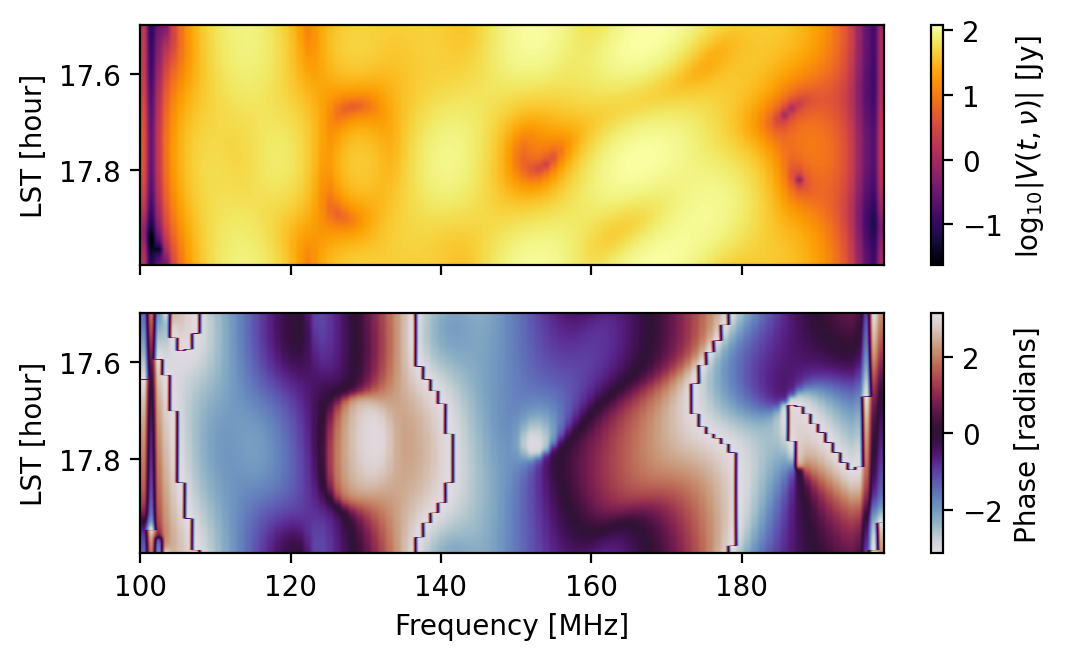

In [53]:
# Let's take a look at some of the data
fig = waterfall(sim)

In [58]:
# Now let's verify that the simulation contains what we want.
print(sim.data.history)

hera_sim v0.0.0: Added diffuseforeground using parameters:
Tsky_mdl = <hera_sim.interpolators.Tsky object at 0x7f416ce86400>
omega_p = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
hera_sim v0.0.0: Added noiselikeeor using parameters:
eor_amp = 0.0001
hera_sim v0.0.0: Added bandpass using parameters:
dly_rng = (-50, 50)



### Using A Configuration File ###

Instead of using a dictionary to specify the parameters, we can instead use a configuration YAML file:

In [61]:
cfg_file = tempdir / "config.yaml"
cfg_file.touch()
with open(cfg_file, "w") as cfg:
    cfg.write(
        """
        pntsrc_foreground:
            nsrcs: 10000
            Smin: 0.2
            Smax: 20
            seed: once
        noiselike_eor:
            eor_amp: 0.005
            seed: redundant
        reflections:
            amp: 0.01
            dly: 200
            seed: once
        """
    )
sim.refresh()
sim.run_sim(sim_file=cfg_file)

FixedFormatter should only be used together with FixedLocator


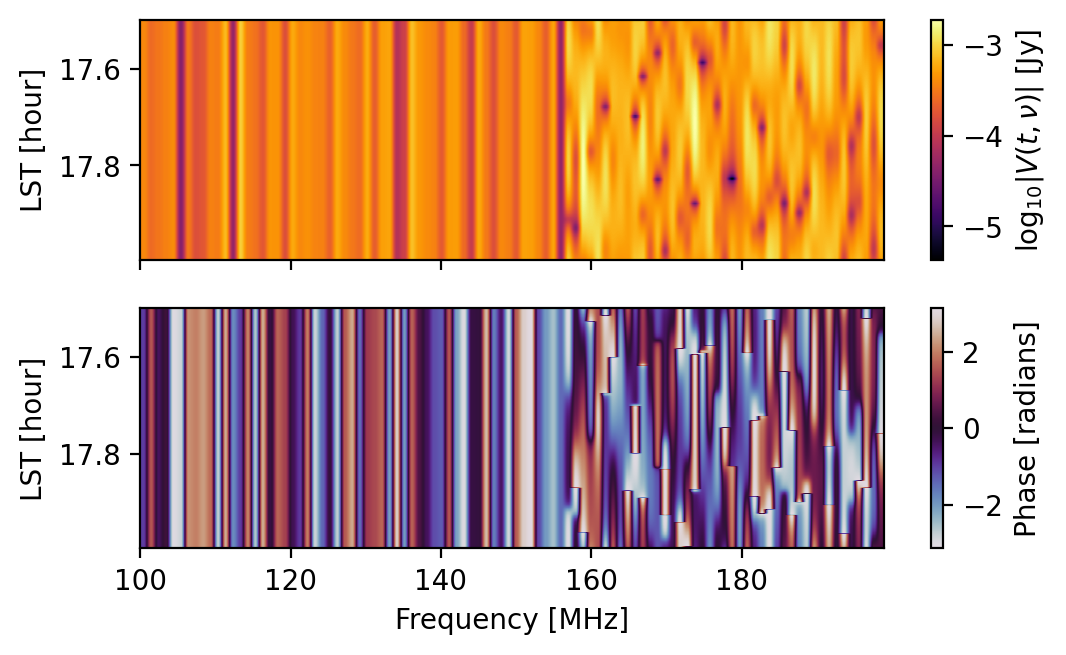

In [62]:
# Again, let's check out some data.
fig = waterfall(sim)

In [63]:
# Then verify the history.
print(sim.data.history)

hera_sim v0.0.0: Added pointsourceforeground using parameters:
nsrcs = 10000
Smin = 0.2
Smax = 20
hera_sim v0.0.0: Added noiselikeeor using parameters:
eor_amp = 0.005
hera_sim v0.0.0: Added reflections using parameters:
amp = 0.01
dly = 200

